# **PayPal 🡲 Membershipworks Migration & Reporting**
## *For the [Ithaca Generator](https://ithacagenerator.org/)*

- - - 

#### *A work in progress by [Jess](https://www.transscendsurvival.org/)*


#### The objectives of this notebook and its scripts are:
##### - Merge PayPal & Membershipworks members in a sorta intelligent way to create kinda accurate financial reports
##### - Convert a PayPal transaction export into an upsert-able csv to import into membershipworks
##### - Keep tabs on PayPal memberships as they become deprecated 



- - - 

## How to use this notebook:

1. export the last three months of paypal transactions as `./csv/paypal_export.CSV` from `https://www.paypal.com/reports/statements/custom`
2. export all current MW member transaction data as `./csv/mw_export.CSV`  from `https://membershipworks.com/admin/#folder/Members`
3. Uncomment "review user" print lines; this script will identify membership discrepancies and alert you to paypal users that have canceled their membership, thus no longer need to be represented in MW as offline users.  Use this information to delete, update, modify users in MW after comparing data in paypal and MW for flagged users.

<div style="page-break-after: always"></div>

\pagebreak


## **August 2022 Financial Stuff:**

![](table_fig.png)

![](gross_income.png)


<div style="page-break-after: always"></div>

\pagebreak

In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from pandas.plotting import table
import datetime
import json
import csv
import random
import math
import random
import shutil
import os

# Plot configurations
# Set matplotlib font size
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24
EXTRACHUNGUS_SIZE = 28
EXTRAJANKY_SIZE = 44

plt.rc('font', size=EXTRACHUNGUS_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=EXTRACHUNGUS_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=EXTRACHUNGUS_SIZE)    # legend fontsize
plt.rc('figure', titlesize=EXTRAJANKY_SIZE)  # fontsize of the figure title

# `Halt()` to quietly exit mid cell:
class HaltNoTrace(Exception):
    def _render_traceback_(self):
        pass

def Halt():
    raise HaltNoTrace
    
# filter out ragged array warning cause i r b lazy:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)         

## file paths:
# paypal csv obtained from `https://www.paypal.com/reports/statements/custom`
paypal_csv_fp = "./csv/paypal_export.CSV"
paypal_df = pd.read_csv(paypal_csv_fp)
print('loaded %d paypal records' % paypal_df.shape[0])

# memebershipworks csv with existing account IDs exported from `https://membershipworks.com/admin/#folder/Members`
mw_ids_csv_fp = "./csv/mw_export.CSV"
mw_ids_df = pd.read_csv(mw_ids_csv_fp, encoding='cp437')
print('loaded %d existing membershipworks records' % mw_ids_df.shape[0])

## files to export

# all members:
membershipworks_import_fp = './csv/membershipworks_import.csv'

# members as of last month:
membershipworks_pastmonth_import_fp = './csv/membershipworks_import_pastmonth.csv'

# establish what one month ago was:
thisMonth = datetime.datetime.today().replace(day=1)
lastMonth = thisMonth - datetime.timedelta(days=31)
priorMonth = lastMonth.replace(day=1) - datetime.timedelta(days=31)

# convert the date column values into python datetime objects:
paypal_df['Date'] = pd.to_datetime(paypal_df['Date'])
print('converted `Date` column to datetime objects')

# transactions below this value are discarded:
min_net = 10
standard_price = 35
   
# keep only rows from within a range:
dates_df = paypal_df[paypal_df['Date'] <= thisMonth]
dates_df = dates_df[dates_df['Date'] >= lastMonth]

print('kept %d records processed between %s and %s; discarded %d records' %
       (dates_df.shape[0],
       lastMonth.__format__('%d/%m/%y').__str__(),
       thisMonth.__format__('%d/%m/%y').__str__(),
       paypal_df.shape[0] - dates_df.shape[0]))


members = []
membership_levels = ['Extra Membership', 
                    'Offline Extra Membership',
                    'Standard Membership', 
                    'Offline Standard Membership',
                    'Offline Basic Membership',
                    'Offline VIP Membership']


memershipworks_df=pd.DataFrame(columns=['Name',
                                        'Email',
                                        'Membership Level',
                                        'Join Date',
                                        'Renewal Date',
                                        'Account ID'])

# is there a level value?
is_lvl = lambda _L: isinstance(_Series[_L].item(), str)

# is there a mw id value?
has_id = has_level = lambda _S: _S.shape[0] 
        
mw_member_names = set(mw_ids_df['Account Name'])
pp_names = paypal_df['Name'].values

for mw_member in mw_member_names:
    
    # get exported MW member info:
    _Series = mw_ids_df[mw_ids_df['Account Name']==mw_member]
    
    try:
        mw_email = _Series['Email'].item()

        # get membership id if we can:
        mw_membership_id = _Series['Account ID']

        # get membership level if we can:
        mw_membership_level = [l for l in membership_levels if is_lvl(l)][0]

        if mw_member not in pp_names and 'Offline' in mw_membership_level:
            # uncomment the following print lines to see paypal and MW discrepancies to investigate
            _ = True  # print(mw_member + ' ' + mw_membership_level)

            if 'Offline Standard' in mw_membership_level or 'Offline Extra' in mw_membership_level:
                _ = True  # print('please REVIEW %s from MW member directory in PayPal' % mw_member)
                

        mw_join_date = pd.to_datetime(_Series['Join Date']).item().__format__('%m/%d/%Y').__str__()
        memershipworks_df.loc[mw_email] = mw_member, mw_email, mw_membership_level, mw_join_date, mw_join_date, mw_membership_id
    
    except:
        # print(mw_email)
        continue
        
memershipworks_df.to_csv(membershipworks_import_fp)

export_str = 'exported: %d Members! \n - %d Standard Members \n - %d Offline Standard Members \n - %d Extra Members \n - %d Offline Extra Members \n ...to a membershipworks-readable format at %s' % (memershipworks_df.shape[0], memershipworks_df[memershipworks_df['Membership Level'] == 'Standard Membership'].shape[0],
 memershipworks_df[memershipworks_df['Membership Level'] == 'Offline Standard Membership'].shape[0],
 memershipworks_df[memershipworks_df['Membership Level'] == 'Extra Membership'].shape[0], 
 memershipworks_df[memershipworks_df['Membership Level'] == 'Offline Extra Membership'].shape[0],
 membershipworks_import_fp)

print(export_str)


loaded 208 paypal records
loaded 106 existing membershipworks records
converted `Date` column to datetime objects
kept 60 records processed between 01/07/22 and 01/08/22; discarded 148 records
exported: 93 Members! 
 - 22 Standard Members 
 - 33 Offline Standard Members 
 - 5 Extra Members 
 - 12 Offline Extra Members 
 ...to a membershipworks-readable format at ./csv/membershipworks_import.csv


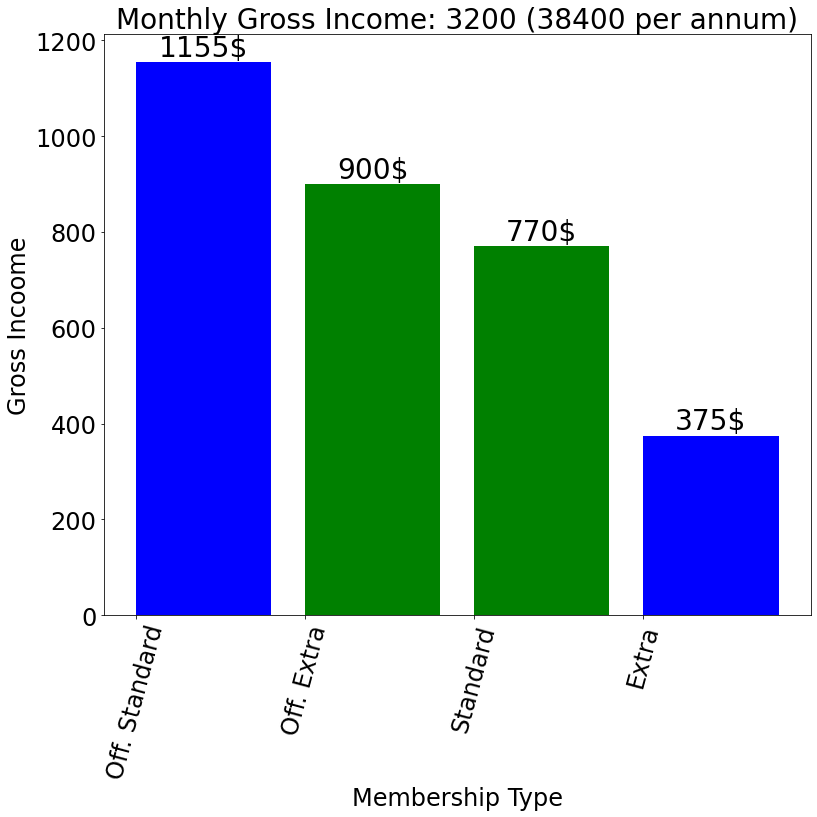

In [15]:
# Plot some stuff:

def bar_view():
    
    offline_extra_ct = memershipworks_df[memershipworks_df['Membership Level'] == 'Offline Extra Membership'].shape[0]
    offline_extra_gross = 75 * offline_extra_ct

    offline_std_ct = memershipworks_df[memershipworks_df['Membership Level'] == 'Offline Standard Membership'].shape[0]
    offline_std_gross = 35 * offline_std_ct

    extra_ct = memershipworks_df[memershipworks_df['Membership Level'] == 'Extra Membership'].shape[0]
    extra_gross = 75 * extra_ct

    std_ct = memershipworks_df[memershipworks_df['Membership Level'] == 'Standard Membership'].shape[0]
    std_gross = 35 * std_ct

    counts = [offline_extra_ct, offline_std_ct, extra_ct, std_ct]
    gross = [offline_extra_gross, offline_std_gross, extra_gross, std_gross]
    labels = ['Off. Extra', 'Off. Standard', 'Extra', 'Standard']

    counts = np.array(counts)
    gross = np.array(gross)
    labels = np.array(labels)

    # sorts our numpy arrays:
    map_sort = lambda *sortables: map(np.array, zip(*sorted(zip(*sortables))))

    # this is the order we'll sort by:
    sortable_arrays = gross, counts, labels

    # apply sort:
    gross, counts, labels = map_sort(*sortable_arrays)

    # reverse so the most prevalent countries are listed first:
    counts = counts[::-1]
    gross = gross[::-1]
    labels = labels[::-1]

    # initialize plot:
    width = 0.8
    fig3 = plt.figure(figsize=(12, 12))
    ax3 = fig3.add_subplot()

    labels_loc = np.arange(len(labels))

    # draw bars:
    rects3 = ax3.bar(labels_loc + width/2, gross, width, label='', color=['blue', 'green', 'green', 'blue'])

    plt.xticks(rotation = 75)
    ax3.set_xlabel('Membership Type')
    ax3.set_ylabel('Gross Incoome')
    ax3.set_title('Monthly Gross Income: %d (%d per annum)' % (sum(gross), sum(gross*12)))

    ax3.set_xticks(labels_loc)
    ax3.set_xticklabels(labels)

    for xy in zip(labels_loc, gross):
        if xy[1]: # if 0, don't plot
            ax3.text(xy[0] + width/2, xy[1], '%s$' % xy[1].__str__(),
                    ha='center', va='bottom')

    fig3.tight_layout()
    plt.tight_layout()
    plt.savefig('gross_income.png')
    
bar_view()

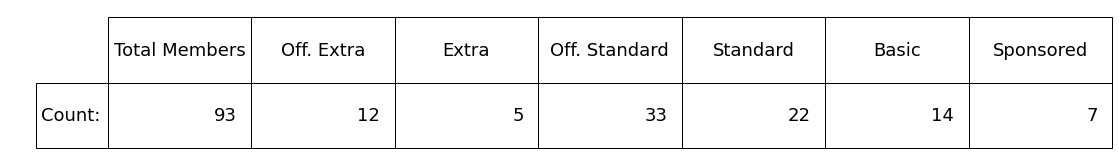

In [16]:
def table_view():   
    
    ## build a table of sums ##
    total_members = memershipworks_df.shape[0]
    offline_extra_members = memershipworks_df[memershipworks_df['Membership Level'] == 'Offline Extra Membership'].shape[0]
    extra_members = memershipworks_df[memershipworks_df['Membership Level'] == 'Extra Membership'].shape[0]
    offline_basic_members = memershipworks_df[memershipworks_df['Membership Level'] == 'Offline Basic Membership'].shape[0]
    offline_std_members = memershipworks_df[memershipworks_df['Membership Level'] == 'Offline Standard Membership'].shape[0]
    std_members = memershipworks_df[memershipworks_df['Membership Level'] == 'Standard Membership'].shape[0]
    spons_members = memershipworks_df[memershipworks_df['Membership Level'] == 'Offline VIP Membership'].shape[0]

    count_df = pd.DataFrame()

    # convert sums with __str__ to avoid recasting
    # as a float when the table gets drawn
    count_df.loc['Count:', 'Total Members'] = total_members.__str__()
    count_df.loc['Count:', 'Off. Extra'] = offline_extra_members.__str__()
    count_df.loc['Count:', 'Extra'] = extra_members.__str__()
    count_df.loc['Count:', 'Off. Standard'] = offline_std_members.__str__()
    count_df.loc['Count:', 'Standard'] = std_members.__str__()
    count_df.loc['Count:', 'Basic'] = offline_basic_members.__str__()
    count_df.loc['Count:', 'Sponsored'] = spons_members.__str__()

    # draw long low table only:
    fig = plt.figure(figsize=(18,2))
    ax = fig.add_subplot(111, frame_on=False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)


    # draw table:
    table_fig = table(ax, count_df, rowLoc='right',
                 colLoc='center', loc='bottom',
                 bbox=[.1, -0.3, 1, 1.2])

    table_fig.auto_set_font_size(False)
    table_fig.set_fontsize(18)

    fig.savefig('table_fig.png')

table_view()